# Movie Reviews - Rotten Tomatoes
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.

test.tsv contains just phrases. You must assign a sentiment label to each phrase.

The sentiment labels are:

0 - negative,1 - somewhat negative,2 - neutral,3 - somewhat positive, 4 - positive

Task and Approach:
Like IMDb , Rotten Tomatoes is also one of the most popular website where people can find reviews and ratings for nearly any movie.
Using TF - IDF we are going Transform phrase in to a normalized tf or tf-idf representation .

TF - How many times a particular word appears in a single doc
IDF - It is calculated by taking the log of {number of docs in your corpus divided by the number of docs in which this term appears}

In [3]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load

import matplotlib.pyplot as plt # Visuvalization & plotting
import seaborn as sns  #Data visualisation

import nltk # Natural Language Toolkit (statistical natural language processing (NLP) libraries )
from nltk.stem.porter import *   # Stemming 

from sklearn.model_selection import train_test_split, cross_val_score
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation

from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier model to predict sentiment

from sklearn.feature_extraction.text import CountVectorizer #CountVectorizer converts collection of text docs to a matrix of token counts

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")
import os

In [12]:
filepath = r"C:\IMS\Term2\TextMining\Case 1"
filename = "train.tsv"
testfilename = "test.tsv"
#data dataframe is train dataframe
#test_df is test dataframe
data = pd.read_csv(os.path.join(filepath, filename),sep='\t')
test_df = pd.read_csv(os.path.join(filepath, testfilename),sep='\t')

In [13]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [14]:
data.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


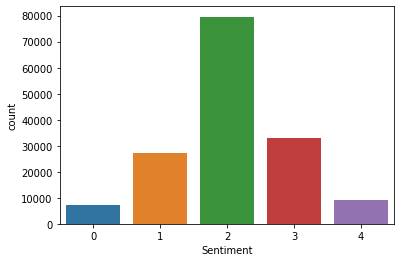

In [15]:
sns.countplot(data=data,x='Sentiment')

In [16]:
dist = data.groupby(["Sentiment"]).size()
print(dist)
print('-'*80)
dist_Percentage = round((dist / dist.sum())*100,2)
print(dist_Percentage)

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
dtype: int64
--------------------------------------------------------------------------------
Sentiment
0     4.53
1    17.48
2    50.99
3    21.10
4     5.90
dtype: float64


In [17]:
data['Length'] = data['Phrase'].apply(lambda x: len(str(x).split(' '))) 

data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Length
0,1,1,A series of escapades demonstrating the adage ...,1,37
1,2,1,A series of escapades demonstrating the adage ...,2,14
2,3,1,A series,2,2
3,4,1,A,2,1
4,5,1,series,2,1


In [18]:
test_df['Length'] = test_df['Phrase'].apply(lambda x: len(str(x).split(' '))) 

test_df.head()

,PhraseId,SentenceId,Phrase,Length
0,156061,8545,An intermittently pleasing but mostly routine ...,8
1,156062,8545,An intermittently pleasing but mostly routine ...,7
2,156063,8545,An,1
3,156064,8545,intermittently pleasing but mostly routine effort,6
4,156065,8545,intermittently pleasing but mostly routine,5


In [24]:
#Check train data Null Values
print("Train Null Values ",data.isnull().sum())
print('*'*80)
#Check test data Null Values
print("Test Null Values ",test_df.isnull().sum())

Train Null Values  PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
Length        0
dtype: int64
********************************************************************************
Test Null Values  PhraseId      0
SentenceId    0
Phrase        0
Length        0
dtype: int64


# Preprocessing Combined train and test data

In [25]:
data['typeofdata']='Train'
test_df['typeofdata']='Test'

In [27]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Length,typeofdata
0,1,1,A series of escapades demonstrating the adage ...,1,37,Train
1,2,1,A series of escapades demonstrating the adage ...,2,14,Train
2,3,1,A series,2,2,Train
3,4,1,A,2,1,Train
4,5,1,series,2,1,Train


In [28]:
combined_df = data.append(test_df, ignore_index=True)
combined_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Length,typeofdata
0,1,1,A series of escapades demonstrating the adage ...,1.0,37,Train
1,2,1,A series of escapades demonstrating the adage ...,2.0,14,Train
2,3,1,A series,2.0,2,Train
3,4,1,A,2.0,1,Train
4,5,1,series,2.0,1,Train


Remove special characters, numbers, punctuations

In [29]:
combined_df['PreProcess_Sentence'] = combined_df['Phrase'].str.replace("[^a-zA-Z#]", " ")

# Converting all data to lower case for uniform processing

In [30]:
combined_df['PreProcess_Sentence'] = combined_df['PreProcess_Sentence'].str.lower()
combined_df['PreProcess_Sentence'].head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: PreProcess_Sentence, dtype: object

# Tokenization i.e. splitting the sentence into individual words to start processing word by word

In [32]:
combined_df['tokenized_words'] = combined_df['PreProcess_Sentence'].apply(lambda x: x.split())
combined_df.tokenized_words.head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: tokenized_words, dtype: object

# Stemming : Convert the words like counting,counted ,counts just as count, --Many variations of words carry the same meaning, other than when tense is involved, One of the most popular stemming algorithms is the Porter stemmer

In [33]:
stemming = PorterStemmer() 
combined_df['tokenized_words'] = combined_df.tokenized_words.apply(lambda x: [stemming.stem(i) for i in x]) # stemming
print(combined_df.tokenized_words.head())

0    [a, seri, of, escapad, demonstr, the, adag, th...
1    [a, seri, of, escapad, demonstr, the, adag, th...
2                                            [a, seri]
3                                                  [a]
4                                               [seri]
Name: tokenized_words, dtype: object


 # TF-IDF usage:  Countvectorizer gives equal weightage to all the words, i.e. a word is converted to a column.  TF-IDF is different from countvectorizer.  vocabulary_ just gives a dict of indexes of the words.

In [34]:
corpus = combined_df.PreProcess_Sentence  ## Collection of documents 
vectorizer = TfidfVectorizer(stop_words='english',analyzer='word')
print(vectorizer)

X = vectorizer.fit_transform(corpus)
print(X[:5])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
  (0, 14593)	0.16241099625722435
  (0, 499)	0.2885844618487239
  (0, 509)	0.3435146841976645
  (0, 10358)	0.24130021014648553
  (0, 6218)	0.3465145071491743
  (0, 6493)	0.29988201399838676
  (0, 6477)	0.33193991688260005
  (0, 162)	0.3280143224723143
  (0, 3824)	0.3246981720495354
  (0, 5076)	0.3625923955084087
  (0, 13415)	0.22233391246874676
  (1, 6493)	0.41934234011258803
  (1, 6477)	0.23208537862340137
  (1, 162)	0.4586813718568841
  (1, 3824)	0.45404420719364774
  (1, 5076)	0.50703388846902

In [35]:
idf = vectorizer.idf_
print(idf)

[11.70258358 10.42164973 11.92572713 ... 10.53943277 10.36758251
 11.52026202]


In [36]:
vectorizer.vocabulary_

{'series': 13415,
 'escapades': 5076,
 'demonstrating': 3824,
 'adage': 162,
 'good': 6477,
 'goose': 6493,
 'gander': 6218,
 'occasionally': 10358,
 'amuses': 509,
 'amounts': 499,
 'story': 14593,
 'quiet': 11950,
 'introspective': 8002,
 'entertaining': 4982,
 'independent': 7648,
 'worth': 17105,
 'seeking': 13323,
 'fans': 5485,
 'ismail': 8090,
 'merchant': 9496,
 'work': 17075,
 'suspect': 14960,
 'hard': 6858,
 'time': 15467,
 'sitting': 13775,
 'positively': 11405,
 'thrilling': 15408,
 'combination': 2766,
 'ethnography': 5123,
 'intrigue': 7989,
 'betrayal': 1350,
 'deceit': 3656,
 'murder': 9941,
 'shakespearean': 13493,
 'tragedy': 15637,
 'juicy': 8295,
 'soap': 14026,
 'opera': 10460,
 'aggressive': 320,
 'self': 13346,
 'glorification': 6424,
 'manipulative': 9229,
 'whitewash': 16906,
 'comedy': 2782,
 'drama': 4451,
 'nearly': 10086,
 'epic': 5025,
 'proportions': 11739,
 'rooted': 12852,
 'performance': 10985,
 'title': 15504,
 'character': 2307,
 'undergoing': 16027

In [37]:
#Print sample features
col = ['features_'+ i for i in vectorizer.get_feature_names()]
print(col[1:5])
print(X[1:5])

['features_aaliyah', 'features_aan', 'features_abagnale', 'features_abandon']
  (0, 6493)	0.41934234011258803
  (0, 6477)	0.23208537862340137
  (0, 162)	0.4586813718568841
  (0, 3824)	0.45404420719364774
  (0, 5076)	0.5070338884690269
  (0, 13415)	0.31090235088768325
  (1, 13415)	1.0
  (3, 13415)	1.0


# Term Frequency tf(t,d) = count of t in d / number of words in d
# Document frequency df(t) = occurrence of t in documents

# Inverse Document Frequency
# IDF is the inverse of the document frequency which measures the informativeness of term t. When we calculate IDF, it will be very low for the most occurring words such as stop words (because stop words such as “is” is present in almost all of the documents, and N/df will give a very low value to that word). This finally gives what we want, a relative weightage.
# idf(t) = N/df

# Now there are few other problems with the IDF, in case of a large corpus, say 10,000, the IDF value explodes. So to dampen the effect we take log of IDF.
# During the query time, when a word which is not in vocab occurs, the df will be 0. As we cannot divide by 0, we smoothen the value by adding 1 to the denominator.
# idf(t) = log(N/(df + 1))
# Finally, by taking a multiplicative value of TF and IDF, we get the TF-IDF score, there are many different variations of TF-IDF but for now let us concentrate on the this basic version.
# tf-idf(t, d) = tf(t, d) * log(N/(df + 1))